## Chapter 1.2: Data Structure and Manipulation
***
In the previous tutorial we saw how we can create a model by calling a few lines of code from imported data. However modelling tends to be an iterative process. Here we will explore the tools that `GemPy` with the help of `pandas` offers to modify the input data of a model.

There is 5 main  funtion "types" in GemPy:

- *create*: 
    - create new objects
    - return the objects
 
- *set*
    - set given values **inplace**

- *update*
    - update dataframe or other attribute from other object or many objects. Usually this object is not passed as argument (this is the main difference with map)

- *map*
    - update dataframe (so far mainly df) or other attribute from an object to another object.
    - Completelly directed. One attribute/property is updated by another one.
    - In general, we map_from so the method is in the mutated object.

- *get*
    - return an image of the object
    
The intention is that a function/method that does not fall in any of these categories has a name (verb in principle) self explanatory. 


As always we start importing the usual packages and reading expample data:

In [1]:
# from IPython.display import IFrame    
# IFrame("https://atlas.mindmup.com/2018/11/ca2c3230ddc511e887555f7d8bb30b4d/gempy_mind_map/index.html",
#       width=1000, height=1000)

In [1]:
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../..")

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import pandas as pn
import matplotlib.pyplot as plt


## Series

Series is the object that contains the properties associated with each sequential pile in general. Right now it is simply the order of the series (which is infered by the index order). But in the future will be add the unconformity relation or perhaps the type of interpolator

In [6]:
faults = gp.Faults()
series = gp.Series(faults)
series.df

,order_series,BottomRelation
Default series,NaN,NaN


We can modify the series bt using `set_series_index`:

In [7]:
series.set_series_index(['foo', 'foo2', 'foo5', 'foo7'])
series

,order_series,BottomRelation
foo,1,NaN
foo2,2,NaN
foo5,3,NaN
foo7,4,NaN


In [8]:
series.df.index

CategoricalIndex(['foo', 'foo2', 'foo5', 'foo7'], categories=['foo', 'foo2', 'foo5', 'foo7'], ordered=True, dtype='category')

For adding new series:

In [9]:
series.add_series('foo3')
series

,order_series,BottomRelation
foo,1,NaN
foo2,2,NaN
foo5,3,NaN
foo7,4,NaN
foo3,5,NaN


Delete series

In [10]:
series.delete_series('foo3')
series

,order_series,BottomRelation
foo,1,NaN
foo2,2,NaN
foo5,3,NaN
foo7,4,NaN


Rename series:

In [11]:
series.rename_series({'foo':'boo'})
series

,order_series,BottomRelation
boo,1,NaN
foo2,2,NaN
foo5,3,NaN
foo7,4,NaN


Reorder series:

In [12]:
series.reorder_series(['foo2', 'boo', 'foo7', 'foo5'])
series

,order_series,BottomRelation
foo2,1,NaN
boo,2,NaN
foo7,3,NaN
foo5,4,NaN


### Faults

The *df faults* is used to charectirize which *mathematical series* behave as fault and if mentioned faults are finite or infinite. Both df should get updated automatically as we modify the series object linked to the fault object (by passing it wehn a Series object is created).

In [15]:
faults

,isFault,isFinite
foo2,NaN,NaN
boo,NaN,NaN
foo7,NaN,NaN
foo5,NaN,NaN


Finally we have the *faults relations df* which captures which *mathematical series* a given fault offset in order to reproduce complex faulting networks

In [16]:
faults.faults_relations_df

,foo2,boo,foo7,foo5
foo2,NaN,NaN,NaN,NaN
boo,NaN,NaN,NaN,NaN
foo7,NaN,NaN,NaN,NaN
foo5,NaN,NaN,NaN,NaN


We can use `set_is_fault` to choose which of our series are faults:

In [18]:
faults.set_is_fault(['boo'])

,isFault,isFinite
foo2,False,NaN
boo,True,NaN
foo7,False,NaN
foo5,False,NaN


Similar thing for the fault relations:

In [20]:
fr = np.zeros((4, 4))
fr[2, 2] = True
faults.set_fault_relation(fr)

,foo2,boo,foo7,foo5
foo2,False,False,False,False
boo,False,False,False,False
foo7,False,False,True,False
foo5,False,False,False,False


Now if we change the series df and we update the series already defined will conserve their values while the new ones will be set to false:

In [21]:
series.add_series('foo20')


In [22]:
series

,order_series,BottomRelation
foo2,1,NaN
boo,2,NaN
foo7,3,NaN
foo5,4,NaN
foo20,5,NaN


In [23]:
faults

,isFault,isFinite
foo2,False,NaN
boo,True,NaN
foo7,False,NaN
foo5,False,NaN
foo20,NaN,NaN


In [24]:
faults.faults_relations_df

,foo2,boo,foo7,foo5,foo20
foo2,False,False,False,False,NaN
boo,False,False,False,False,NaN
foo7,False,False,True,False,NaN
foo5,False,False,False,False,NaN
foo20,NaN,NaN,NaN,NaN,NaN


### Formations:

The *df* formation contain three properties. *id* refers to the order of the formation on the sequential pile, i.e. the strict order of computation. *values* on the other hand is the final value that each voxel will have after discretization. This may be useful for example in the case we want to map a specific geophysical property (such as density) to a given unity. By default both are the same since to discretize lithological units the value is arbitrary.

#### From an empty df

In [53]:
f = gp.Formations(series)

In [54]:
f

,formation,series,id,isBasement


In [55]:
f.set_formation_names_pro(['foo', 'foo2', 'foo5'])


True

In [56]:
f

,formation,series,id,isBasement
0,foo,foo2,1,False
1,foo2,foo2,2,False
2,foo5,foo2,3,False


In [140]:
f.add_formation(['feeeee'])

True

In [58]:
f.df['formation']

0     foo
1    foo2
2    foo5
3     fee
Name: formation, dtype: category
Categories (4, object): [foo, foo2, foo5, fee]

### Set values

In [59]:
f.set_formation_values_pro([2,2,2,5])

True

In [42]:
f

,formation,series,id,isBasement,value_0
0,foo,foo2,1,False,2
1,foo2,foo2,2,False,2
2,foo5,foo2,3,False,2
3,fee,NaN,4,False,5


#### Set values with a given name:

In [60]:
f.add_formation_values_pro([[2,2,2,6], [2,2,1,8]], ['val_foo', 'val2_foo'])

True

In [61]:
f

,formation,series,id,isBasement,value_0,val_foo,val2_foo
0,foo,foo2,1,False,2,2,2
1,foo2,foo2,2,False,2,2,2
2,foo5,foo2,3,False,2,2,1
3,fee,NaN,4,False,5,6,8


### Delete formations values

In [47]:
f.delete_formation_values(['val_foo', 'value_0'])

True

In [48]:
f.set_basement()
f

,formation,series,id,isBasement,val2_foo
0,foo,foo2,1,False,2
1,foo2,foo2,2,False,2
2,foo5,foo2,3,False,1
3,fee,NaN,4,False,8


#### Set formation values

In [49]:
f.set_formation_values_pro([[2,2,2,6], [2,2,1,8]], ['val_foo', 'val2_foo'])
f

,formation,series,id,isBasement,val_foo,val2_foo
0,foo,foo2,1,False,2,2
1,foo2,foo2,2,False,2,2
2,foo5,foo2,3,False,2,1
3,fee,NaN,4,False,6,8


The last property is the correspondant series that each formation belong to. `series` and `formation` are pandas categories. To get a overview of what this mean check https://pandas.pydata.org/pandas-docs/stable/categorical.html.

In [64]:
f.df['series']

0    foo2
1    foo2
2    foo2
3     NaN
Name: series, dtype: category
Categories (5, object): [foo2, boo, foo7, foo5, foo20]

In [65]:
f.df['formation']

0     foo
1    foo2
2    foo5
3     fee
Name: formation, dtype: category
Categories (4, object): [foo, foo2, foo5, fee]

### Map series to formation

To map a series to a formation we can do it by passing a dict:

In [67]:
f

,formation,series,id,isBasement,value_0,val_foo,val2_foo
0,foo,foo2,1,False,2,2,2
1,foo2,foo2,2,False,2,2,2
2,foo5,foo2,3,False,2,2,1
3,fee,NaN,4,False,5,6,8


In [68]:
series

,order_series,BottomRelation
foo2,1,NaN
boo,2,NaN
foo7,3,NaN
foo5,4,NaN
foo20,5,NaN


If a series does not exist in the `Series` object, we rise a warning and we set those formations to nans

In [75]:
d =  {"foo7":'foo', "booX": ('foo2','foo5', 'fee')}

In [76]:
f.map_series(d)

../../gempy/core/data.py:611: UserWarning: Some of the formations are not in the dictionary or some of the keys are not in theseries object. 
 Formations:1    foo2
2    foo5
3     fee
Categories (4, object): [foo, foo2, foo5, fee]
 Series: ['booX' 'booX' 'booX']
  missfit = self.df['formation'][nans]


In [77]:
f.map_series({"foo7":'foo', "boo": ('foo2','foo5', 'fee')})

In [78]:
f

,formation,series,id,isBasement,value_0,val_foo,val2_foo
0,foo,foo7,1,False,2,2,2
1,foo2,boo,2,False,2,2,2
2,foo5,boo,3,False,2,2,1
3,fee,boo,4,False,5,6,8


An advantage of categories is that they are order so no we can tidy the df by series and formation

In [79]:
f.df.sort_values(by='series', inplace=True)

If we change the basement:

In [92]:
f.set_basement('foo5')

Only one formation can be the basement:

In [93]:
f

,formation,series,id,isBasement,value_0,val_foo,val2_foo
1,foo2,boo,2,False,2,2,2
2,foo5,boo,3,True,2,2,1
3,fee,boo,4,False,5,6,8
0,foo,foo7,1,False,2,2,2


### Modify values

In [106]:
f.rename_formations({'foo2':'lala'})

In [110]:
f.df['formation'].cat.rename_categories({'foo2':'lala'}, inplace=True)

In [111]:
f

,formation,series,id,isBasement,value_0,val_foo,val2_foo
1,lala,boo,2.0,False,2.0,2.0,2.0
2,foo5,boo,3.0,True,2.0,2.0,1.0
3,fee,boo,4.0,False,5.0,6.0,8.0
0,foo,foo7,1.0,False,2.0,2.0,2.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
f.df.loc[2, 'val_foo'] = 22

In [113]:
f

,formation,series,id,isBasement,value_0,val_foo,val2_foo
1,lala,boo,2.0,False,2.0,2.0,2.0
2,foo5,boo,3.0,True,2.0,22.0,1.0
3,fee,boo,4.0,False,5.0,6.0,8.0
0,foo,foo7,1.0,False,2.0,2.0,2.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
f.update_sequential_pile()

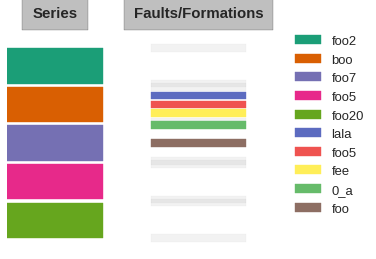

In [117]:
f.sequential_pile.figure

# Data

In [126]:
interfaces = gp.Interfaces()
orientations = gp.Orientations()

In [144]:
interfaces.df['formation'].cat.set_categories(f.df['formation'].cat.categories, inplace=True)
interfaces.df['series'].cat.set_categories(f.df['series'].cat.categories, inplace=True)

In [145]:
interfaces.df['series']

Series([], Name: series, dtype: category
Categories (5, object): [foo2, boo, foo7, foo5, foo20])

In [150]:
interfaces.df['formation']

0    NaN
Name: formation, dtype: category
Categories (5, object): [foo, lala, foo5, fee, feeeee]

In [148]:
interfaces.df.loc[0, ['X', 'Y', 'Z']] = np.arange(3)

In [151]:
interfaces.df

,X,Y,Z,formation,series,id,order_series,isFault
0,0.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN


In [154]:
interfaces.df.loc[0, 'formation'] = 'i'

ValueError: Cannot setitem on a Categorical with a new category, set the categories first

In [155]:
interfaces.df.loc[0, 'formation'] = 'foo'
interfaces

,X,Y,Z,formation,series,id,order_series,isFault
0,0.0,1.0,2.0,foo,NaN,NaN,NaN,NaN


In [45]:
gp.map_to_data(geo_model, geo_model.series, geo_model.formations, geo_model.faults)

In [47]:
geo_model.interfaces.sort_table()
geo_model.orientations.sort_table()
geo_model.interfaces

,X,Y,Z,formation,series,id,order_series,isFault,X_r,Y_r,Z_r
52,700.0,1000.0,900.0,Main_Fault,Fault_Series,1,1,True,0.460626,0.500100,0.500100
53,600.0,1000.0,600.0,Main_Fault,Fault_Series,1,1,True,0.434311,0.500100,0.421153
54,500.0,1000.0,300.0,Main_Fault,Fault_Series,1,1,True,0.407995,0.500100,0.342205
55,800.0,1000.0,1200.0,Main_Fault,Fault_Series,1,1,True,0.486942,0.500100,0.579047
56,900.0,1000.0,1500.0,Main_Fault,Fault_Series,1,1,True,0.513258,0.500100,0.657995
44,0.0,1000.0,1500.0,Sandstone_2,Strat_Series,2,2,False,0.276416,0.500100,0.657995
45,300.0,1000.0,1400.0,Sandstone_2,Strat_Series,2,2,False,0.355363,0.500100,0.631679
46,600.0,1000.0,1300.0,Sandstone_2,Strat_Series,2,2,False,0.434311,0.500100,0.605363
47,1100.0,1000.0,1300.0,Sandstone_2,Strat_Series,2,2,False,0.565889,0.500100,0.605363
48,1400.0,1000.0,1250.0,Sandstone_2,Strat_Series,2,2,False,0.644837,0.500100,0.592205


### Additional Data

In [48]:
geo_model.additional_data

values
Structure isLith                                                                     True
          isFault                                                                   False
          number faults                                                                 0
          number formations                                                             6
          number formations per series                                                 []
          len formations interfaces                                    [16, 15, 13, 8, 5]
          len series interfaces                                                       [0]
          len series orientations                                                      []
Options   dtype                                                                   float64
          output                                                                  geology
          theano_optimizer                                                   fast_compile
          device                                                                      cpu
          verbosity                                                                   NaN
Kringing  range                                                                    3464.1
          $C_o$                                                                    285714
          drift equations                                                             [0]
          nugget grad                                                                0.01
          nugget scalar                                                             1e-06
Rescaling rescaling factor                                                           3800
          centers                       X     850.0
Y    1000.0
Z     900.0
dtype: flo...

The class `gempy.core.model.Model` works as the parent container of our project. Therefore the main step of any project is to create an instance of this class. In the official documentation we use normally geo_model (geo_data in the past) as name of this instance.

When we instiantiate a `Model` object we full data structure is created. By using `gp.init_data` and `set_series` we set the default values -- given the attributes -- to all of fields. Data is stored in pandas dataframes. With `gp.get_data` and the name of the data object it is possible to have access to the dataframes: 

`str`['all', 'interfaces', 'orientations', 'formations', 'series', 'faults', 'faults_relations', 
        additional data]
        
These dataframes are stored in specific objects. These objects contain the specific methods to manipulate them. You access these objects with the spectific getter or as a attribute of `Model`

### Additional Data

In [11]:
gp.get_additional_data(geo_model)

values
Structure isLith                                                                     True
          isFault                                                                    True
          number faults                                                                 1
          number formations                                                             6
          number formations per series                                             [1, 5]
          len formations interfaces                                    [5, 8, 13, 16, 15]
          len series interfaces                                                   [5, 52]
          len series orientations                                                  [1, 2]
Options   dtype                                                                   float64
          output                                                                  geology
          theano_optimizer                                                   fast_compile
          device                                                                      cpu
          verbosity                                                                   NaN
Kringing  range                                                                    3464.1
          $C_o$                                                                    285714
          drift equations                                                          [3, 3]
          nugget grad                                                                0.01
          nugget scalar                                                             1e-06
Rescaling rescaling factor                                                           3800
          centers                       X     850.0
Y    1000.0
Z     900.0
dtype: flo...

In [12]:
gp.get_data(geo_model, 'additional data')

values
Structure isLith                                                                     True
          isFault                                                                    True
          number faults                                                                 1
          number formations                                                             6
          number formations per series                                             [1, 5]
          len formations interfaces                                    [5, 8, 13, 16, 15]
          len series interfaces                                                   [5, 52]
          len series orientations                                                  [1, 2]
Options   dtype                                                                   float64
          output                                                                  geology
          theano_optimizer                                                   fast_compile
          device                                                                      cpu
          verbosity                                                                   NaN
Kringing  range                                                                    3464.1
          $C_o$                                                                    285714
          drift equations                                                          [3, 3]
          nugget grad                                                                0.01
          nugget scalar                                                             1e-06
Rescaling rescaling factor                                                           3800
          centers                       X     850.0
Y    1000.0
Z     900.0
dtype: flo...

###  Interfaces

These two DataFrames (df from now on) will contain the individual information of each point at an interface or orientation. Some properties of this table are mapped from the *df* below.

In [13]:
gp.get_data(geo_model, 'interfaces').head()

,X,Y,Z,formation,series,id,order_series,isFault
0,800.0,50.0,750.0,Shale,Strat_Series,4,2,False
1,800.0,150.0,700.0,Shale,Strat_Series,4,2,False
2,800.0,300.0,700.0,Shale,Strat_Series,4,2,False
3,800.0,500.0,800.0,Shale,Strat_Series,4,2,False
4,800.0,1000.0,1000.0,Shale,Strat_Series,4,2,False


### Orientations

In [14]:
gp.get_data(geo_model, 'orientations').head()

,X,Y,Z,G_x,G_y,G_z,dip,azimuth,polarity,formation,series,id,order_series,isFault
0,1000.0,1000.0,950.000,0.316229,1.000019e-12,0.948683,18.435,90.0,1.0,Shale,Strat_Series,4,2,False
1,400.0,1000.0,1400.000,0.316229,1.000019e-12,0.948683,18.435,90.0,1.0,Sandstone_2,Strat_Series,2,2,False
2,500.0,1000.0,864.602,-0.948683,9.998257e-13,0.316229,71.565,270.0,1.0,Main_Fault,Fault_Series,1,1,True


These objects contain and represent all necessary data to create a model.

### Adding, modifing deleting

In [6]:
geo_model.modify_interfaces([0], X=[2000], Y=[2000], Z=[2000])

#### Passing a vtk object to real time update

In [5]:
v = gp.plot.plot_data_3D(geo_model)

closing vtk


In [10]:
isinstance(v, gp.plot.vtkPlot)

True

In [17]:
geo_model.modify_interfaces([0], v,  X=[2000], Y=[2000], Z=[1000])

In [ ]:
v.close()

##### Real time surface updating


In [49]:
gp.set_interpolation_data(geo_model, theano_optimizer='fast_run')

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of df:  1


,values
dtype,float64
output,geology
theano_optimizer,fast_run
device,cpu
verbosity,NaN


In [23]:
gp.compute_model(geo_model)


Lithology ids 
  [6. 6. 6. ... 2. 2. 2.] 
Lithology scalar field 
  [30.32253075 30.34951782 30.37647057 ... 30.97820663 31.01681709
 31.0546608 ] 
Fault block 
  [[1. 1. 1. ... 2. 2. 2.]]

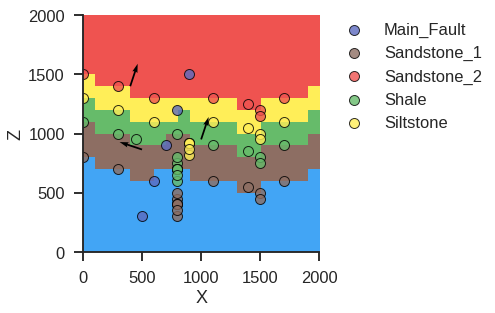

In [25]:
gp.plot.plot_section(geo_model, 10, plot_data=True)

In [25]:
gp.save_model(geo_model, './saves/ch1-2-vr')

True

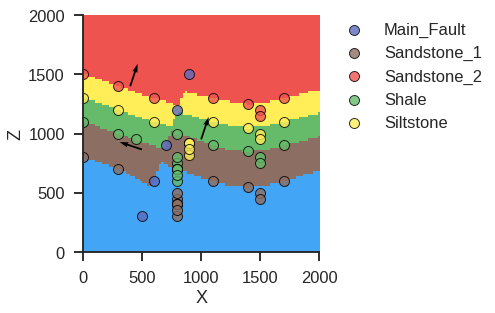

In [4]:
gp.plot.plot_section(geo_model, 50, plot_data=True)

In [5]:
v = gp.plot.plot_surfaces_3D_real_time(geo_model, None, None)

holding... Use vtk.resume to go back to the interactive window


In [12]:
geo_model.modify_interfaces([0], v,  X=[2000], Y=[2000], Z=[1000])

In [14]:
v.close()

### Modify other dataframes

In [47]:
geo_model.additional_data.kriging_data

,values
range,3464.1
$C_o$,285714
drift equations,"[3, 3]"
nugget grad,3
nugget scalar,3


In [11]:
geo_model.additional_data.kriging_data.loc[['nugget scalar', 'nugget grad'], 'values'] = [1000,1000]
geo_model.interpolator.set_theano_shared_kriging()


In [6]:
geo_model.additional_data.kriging_data.loc[['nugget scalar', 'nugget grad'], 'values'] = [1000,3]

In [70]:
geo_model.additional_data.kriging_data.loc['nugget scalar', 'values'] = 1e-6
geo_model.additional_data.kriging_data.loc['nugget grad', 'values'] = 0.01

In [38]:
geo_model.additional_data.kriging_data.loc['nugget scalar', 'values'] = 1
geo_model.additional_data.kriging_data.loc['nugget grad', 'values'] = 1

In [10]:
geo_model.interpolator.set_theano_shared_kriging()
v.vv.update_surfaces_real_time()
v.vv.interactor.Render()